## Import Libraries

In [1]:
#from google.colab import drive
import os
import shutil
import numpy as np
import random as rn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
from sklearn import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer

from keras.applications import VGG16
from keras.models import Sequential ,load_model
from keras.layers import Dense, Dropout, Flatten


## Google Drive connection

In [2]:
# mount drive 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Utilities

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os

from tensorflow.keras import backend as K
from itertools import cycle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score

# # su colab
dataset_path = "/content/drive/MyDrive/BrainTumorDataset"

# # Percorso della cartella "unified" che contiene le sottocartelle delle classi
base_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Unified"

# Definisci i percorsi per il set di test, di validazione e di addestramento
test_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Test"
val_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Validation"
train_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Train"
models_path = "/content/drive/MyDrive/BrainTumorDataset/Models"
# # per locale
#dataset_path = "BrainTumorDataset"

# Percorso della cartella "unified" che contiene le sottocartelle delle classi
#base_path = "BrainTumorDataset/Preprocessed/Unified"

# Definisci i percorsi per il set di test, di validazione e di addestramento
#test_path = "BrainTumorDataset/Preprocessed/Test"
#val_path = "BrainTumorDataset/Preprocessed/Validation"
#train_path = "BrainTumorDataset/Preprocessed/Train"

#models_path = "BrainTumorDataset/Models"

cnn_results_path = os.path.join(models_path, 'CNN')
vgg16_results_path = os.path.join(models_path, 'VGG16')
resnet50_results_path = os.path.join(models_path, 'ResNet50')
inceptionv3_results_path = os.path.join(models_path, 'InceptionV3')

def set_seed ():
	''' 
	set_seed is used to obtain reproducible results using keras during the development phase
	'''
	seed = 10
	# The below is necessary for reproducible results of certain Python hash-based operations.
	os.environ["PYTHONHASHSEED"]="0"
	# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
	np.random.seed(seed)
	# The below is necessary for starting core Python generated random numbers in a well-defined state.
	rn.seed(seed)
	# The below tf.random.set_seed will make x number generation in TensorFlow have a well-defined initial state.
	tf.random.set_seed(seed)     

# Definisci le dimensioni delle immagini
image_size = 224
batch_size = 32

# Crea un oggetto ImageDataGenerator per il preprocessing delle immagini
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Carica le immagini dal set di addestramento
train_generator = data_generator.flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

# Carica le immagini dal set di test
test_generator = data_generator.flow_from_directory(
    test_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Carica le immagini dal set di validazione
val_generator = data_generator.flow_from_directory(
    val_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)
     

def show_training_and_validation_performance(history,path):
	'''
	show_training_and_validation_performance is used to plot the performances during the training phase
	:param history: object in which are recorded all the events
	'''
	acc = history.history['accuracy']
	val_acc = history.history['val_accuracy']
	loss = history.history['loss']
	val_loss = history.history['val_loss']

	epochs = range(len(acc))

	plt.plot(epochs, acc, 'bo', label='Training accuracy')
	plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
	plt.title('Training and validation accuracy')
	plt.legend()

	plt.figure()

	plt.plot(epochs, loss, 'bo', label='Training loss')
	plt.plot(epochs, val_loss, 'b', label='Validation loss')
	plt.title('Training and validation loss')
	plt.legend()

	plt.savefig(path)

	plt.show()

def compile_model (model, optimizer='adam', learning_rate = 0.001):
	'''
	compile_model is used to compile the current model
	:param model: model to compile
	:param optimizer: optimizer to be used
	:param learning_rate: learning rate parameter for the optimizer
	'''
	if optimizer == 'adam':
		model.compile(loss="categorical_crossentropy",
		optimizer=optimizers.Adam(learning_rate=learning_rate),
		metrics=["accuracy"])
	elif optimizer == 'rmsprop':
		model.compile(loss="categorical_crossentropy",
					optimizer = optimizers.RMSprop(learning_rate=learning_rate),
					metrics=['accuracy'])
	model.summary()

def run_model (model, type, model_name, epochs = 100, patience=5, monitor='val_loss'):
	'''
	run_model is used to run the current mode
	:param model: model to run
	:param model_name: name given to save the model
	:param type: type of model, CNN, VGG16, ResNet50, InceptionV3
	:param epochs: how many epochs to do
	:param patience: patience value for Early Stopping
	:param monitor: what to monitor for Early Stopping and Model Checkpoint
	'''
	# local save path for the models
	save_path = os.path.join(models_path, type + '/' + model_name + '.h5') 
	callbacks_list = [
					keras.callbacks.EarlyStopping(monitor=monitor, patience=patience),
					keras.callbacks.ModelCheckpoint(
						filepath = save_path,
						monitor=monitor,
						verbose=1,
						save_best_only=True)
					]
	history = model.fit(train_generator,
						epochs=epochs,
						validation_data=val_generator,
						callbacks=callbacks_list)
	# save on Drive only the best model
	show_training_and_validation_performance(history,os.path.join(models_path, type + '/' + model_name + '_validation.png'))

def plot_roc_curve(y_true, y_pred, n_classes, class_labels, model_name, type):

    # Converti le etichette di classe in formato binario
    lb = LabelBinarizer()
    y_true_binary = lb.fit_transform(y_true)

    # Calcola i tassi di FPR e TPR per ogni classe
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_true_binary[:, i], y_pred[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    plt.figure()
    colors = ['blue', 'red', 'green', 'orange']  # Colori per le diverse classi

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, label='ROC curve {0} ({1:0.2f}%)'.format(class_labels[i], roc_auc[i]*100))

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(models_path, type + '/' + model_name + '_ROC.png'))
    plt.show()

def evaluate_model (model, test_generator, model_name, type):
	'''
	evaluate_model is used to plot some statistics about the performance on the test set
	:param model: model to consider
	'''
	labels_d= ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

	# get predictions
	y_score = model.predict(test_generator)
	# convert predictions to classes
	y_pred = np.argmax(y_score, axis=-1)
	# get true classes
	y_true = test_generator.classes
	# extract class labels
	class_labels = list(test_generator.class_indices.keys())
	
	print("Classification report: ")
	# create and show classification report
	print(metrics.classification_report(y_true, y_pred, target_names=class_labels,digits = 4))
	# save classification report
	with open(os.path.join(models_path, type + '/' + model_name + '_classification_report.txt'), 'w') as f:
		f.write(metrics.classification_report(y_true, y_pred, target_names=class_labels,digits = 4))

	# create and show confusion matrix	
	cm = confusion_matrix(y_true, y_pred)	
	disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
	disp.plot(xticks_rotation=45)
	
	# save confusion matrix
	plt.savefig(os.path.join(models_path, type, model_name + '_confusion_matrix.png'), bbox_inches='tight', pad_inches=0.1)
	plt.show()

	plot_roc_curve(y_true, y_score, 4, class_labels, model_name, type)

def display_feature_map(layer_names,activations):
	# Now let's display our feature maps
	for layer_name, layer_activation in zip(layer_names, activations):
			# This is the number of features in the feature map
			n_features = layer_activation.shape[-1]

			# The feature map has shape (1, size, size, n_features)
			size = layer_activation.shape[1]

			# We will tile the activation channels in this matrix
			n_cols = n_features // images_per_row
			display_grid = np.zeros((size * n_cols, images_per_row * size))

			# We'll tile each filter into this big horizontal grid
			for col in range(n_cols):
					for row in range(images_per_row):
							channel_image = layer_activation[0,:, :, col * images_per_row + row]
							# Post-process the feature to make it visually palatable
							channel_image -= channel_image.mean()
							channel_image /= channel_image.std()
							channel_image *= 64
							channel_image += 128
							channel_image = np.clip(channel_image, 0, 255).astype('uint8')
							display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

			# Display the grid
			scale = 1. / size
			plt.figure(figsize=(scale * display_grid.shape[1],
													scale * display_grid.shape[0]))
			plt.title(layer_name)
			plt.grid(False)
			plt.imshow(display_grid, aspect='auto', cmap='gray')
			
	plt.show()

def get_img(img_path, target_size=(224,224)):
    img = image.load_img(img_path, target_size=target_size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def get_img_for_pred(img_path, target_size=(224,224)):
	img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
	img_tensor = tf.keras.preprocessing.image.img_to_array(img)  # (height, width, channels)
	img_tensor = np.expand_dims(img_tensor, axis=0) 
	img_tensor /= 255.
	return img_tensor

def decode_predictions(pred):
	class_indices = np.argsort(pred)[0, ::-1][:4]  # Ottieni gli indici delle probabilità ordinate in modo decrescente per le prime 4 classi
	class_probabilities = pred[0, class_indices]  # Probabilità corrispondenti alle classi selezionate
	class_labels = [labels_dict[i] for i in class_indices]  # Etichette corrispondenti alle classi selezionate

	for label, probability in zip(class_labels, class_probabilities):
		print(f"{label}: {probability*100:.2f}%")

def get_last_conv_layer(model):
	conv_layer_names = []
	last_conv_layer = None
	for layer in model.layers[::-1]:
		if isinstance(layer, keras.layers.Conv2D):
			last_conv_layer = layer
			break
		else:
			conv_layer_names.append(layer.name)
	conv_layer_names = conv_layer_names[::-1]
	return last_conv_layer, conv_layer_names

def create_heatmap(img_array,img_tensor,last_conv_layer_model,classifier_model):
	#compute gradient for input image respect to the activations of the last convolution layer
	with tf.GradientTape() as tape:
		last_conv_layer_output = last_conv_layer_model(img_tensor) # output feature maps of the last conv layer.
		tape.watch(last_conv_layer_output)
		preds = classifier_model(last_conv_layer_output)  
		top_pred_index = tf.argmax(preds[0])  #  meningioma_tumor prediction index
		top_class_channel = preds[:, top_pred_index] # meningioma_tumor prediction value
	#Gradient of the meningioma_tumor class with related to the output feature maps of last conv layer
	grads = tape.gradient(top_class_channel, last_conv_layer_output) 
	#Apply pooling and importance weighting to the gradient tensor to obtain heatmap of class activation
	pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy() # evaluate the mean over the gradient tensor, for each channel separately
	
	weighted_last_conv_layer_output = last_conv_layer_output.numpy()[0]
	for i in range(pooled_grads.shape[-1]):
		weighted_last_conv_layer_output[:, :, i] *= pooled_grads[i]
	
	heatmap = np.mean(weighted_last_conv_layer_output, axis=-1)
	heatmap = np.maximum(heatmap, 0)
	heatmap /= np.max(heatmap)

	# Crea una figura e una griglia di subplot 1x2
	fig, axs = plt.subplots(1, 2)

	# Stampa l'immagine 'heatmap' nel subplot sinistro
	axs[0].matshow(heatmap)

	# Stampa l'immagine 'img_tensor' nel subplot destro
	axs[1].imshow(img_array[0].astype('uint8'))

	# Rimuovi gli assi (opzionale)
	axs[0].axis('off')
	axs[1].axis('off')

	# Mostra la figura
	plt.show()
	return heatmap

def superimposed_img(img_path,heatmap,save_path):
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    superimposed_img.save(save_path)
    plt.figure(figsize= (10,10))
    plt.imshow(superimposed_img)    

def clear(model):
	del model
	K.clear_session() 

set_seed ()

Found 4520 images belonging to 4 classes.
Found 652 images belonging to 4 classes.
Found 652 images belonging to 4 classes.


## Load VGG16

In [ ]:
# Carica il modello VGG16 pre-addestrato, senza l'ultimo strato fully connected
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
base_model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

# Feature Extraction

## Experiment 1
VGG16 + dense layer 128 neuron

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 17,926,596
Trainable params: 3,211,908
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/100
142/142 [====================

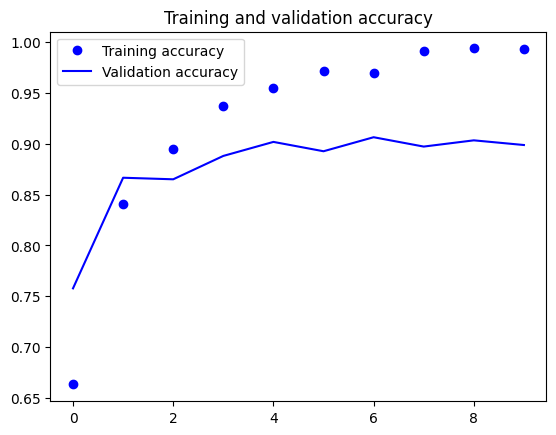

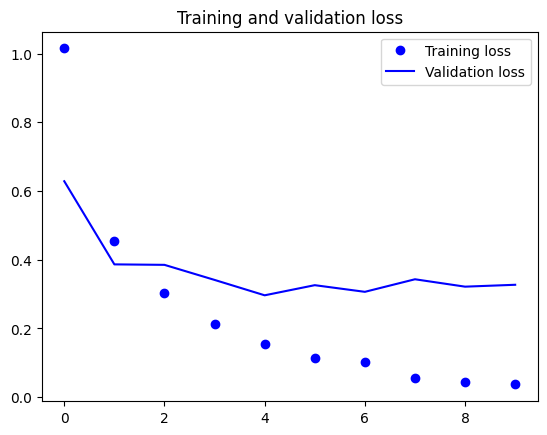

21/21 [==============================] - 283s 14s/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.8607    0.9351    0.8964       185
meningioma_tumor     0.9212    0.8128    0.8636       187
        no_tumor     0.8857    0.9300    0.9073       100
 pituitary_tumor     0.9558    0.9611    0.9584       180

        accuracy                         0.9064       652
       macro avg     0.9059    0.9098    0.9064       652
    weighted avg     0.9081    0.9064    0.9058       652



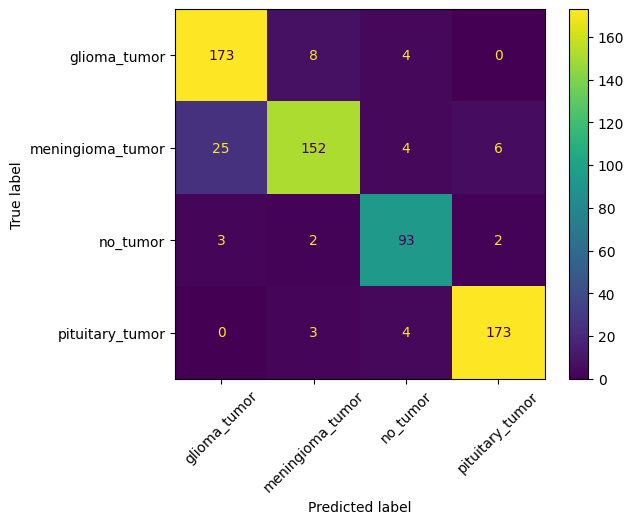

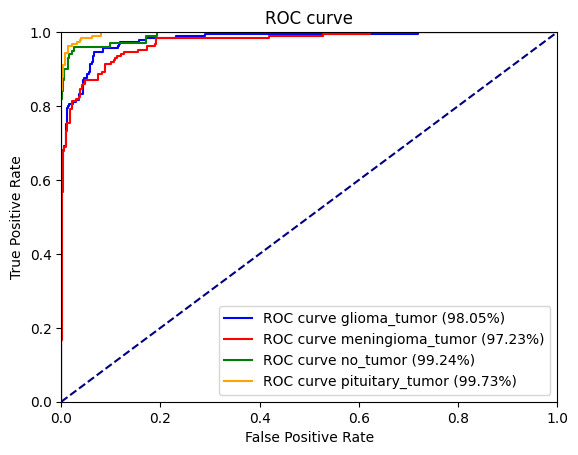

In [ ]:
# Aggiungi un nuovo strato fully connected all'ultimo layer di VGG16
inputs = keras.Input(shape=(image_size, image_size, 3))
x = base_model(inputs)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(4, activation="softmax")(x)#4 classi di output
model = keras.Model(inputs=inputs, outputs=outputs)

# Congela i pesi del modello base, così da mantenere l'informazione appresa
for layer in base_model.layers:
    layer.trainable = False

# Compila il modello
compile_model(model)

# Addestra il modello
run_model(model,"VGG16","VGG16_128")

# Valuta il modello
evaluate_model(model,test_generator,"VGG16_128","VGG16")

### suggerimento : 

Se la curva di validation dell'accuracy oscilla, alza e abbassa, potrebbe essere un segnale di overfitting. Questo perché il modello sta diventando troppo complesso e si sta adattando troppo bene ai dati di addestramento. Inoltre, l'oscillazione potrebbe essere dovuta alla presenza di troppa varianza nei dati di addestramento o ad una dimensione insufficiente del dataset di addestramento.

Un altro possibile motivo per cui la curva di validation dell'accuracy oscilla potrebbe essere la sensibilità del modello alla configurazione dei dati di addestramento e di validazione. Ad esempio, se la suddivisione dei dati di addestramento e di validazione non è stata effettuata in modo casuale, potrebbe esserci una certa correlazione tra i dati di addestramento e quelli di validazione che potrebbe influenzare la performance del modello.

In generale, se la curva di validation dell'accuracy oscilla, alza e abbassa, si consiglia di utilizzare tecniche di regolarizzazione come dropout o l1/l2 regularization per ridurre l'overfitting. Inoltre, potrebbe essere utile aumentare la dimensione del dataset di addestramento o utilizzare tecniche di data augmentation per aumentare la varietà dei dati di addestramento. Infine, è possibile considerare l'utilizzo di modelli più semplici o l'ottimizzazione dei parametri del modello per migliorare le performance.

## Experiment 2
VGG16 + dense layer 128 neurons and dropout 

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 25088)             0         
                                                                 
 dense_10 (Dense)            (None, 128)               3211392   
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 4)                 516       
                                                                 
Total params: 17,926,596
Trainable params: 3,211,908
Non-tr

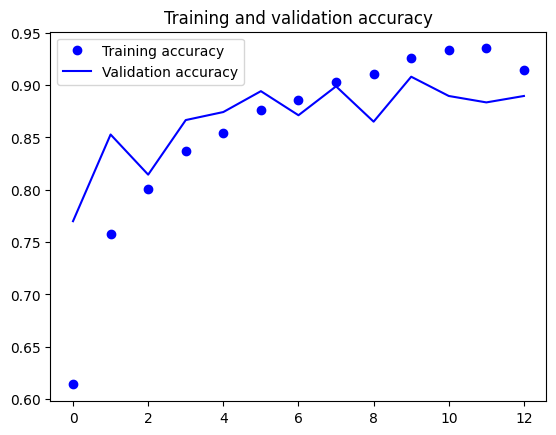

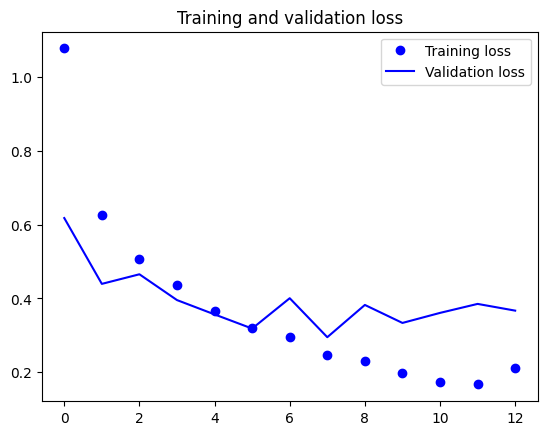

21/21 [==============================] - 5s 248ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.9419    0.7892    0.8588       185
meningioma_tumor     0.8351    0.8663    0.8504       187
        no_tumor     0.8319    0.9400    0.8826       100
 pituitary_tumor     0.9053    0.9556    0.9297       180

        accuracy                         0.8804       652
       macro avg     0.8785    0.8878    0.8804       652
    weighted avg     0.8843    0.8804    0.8796       652



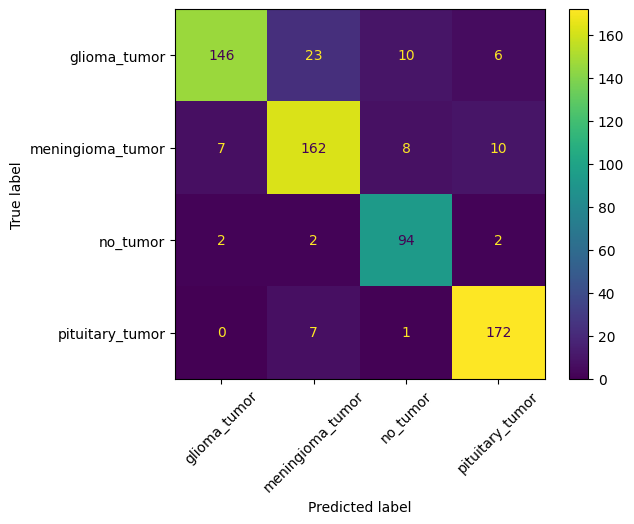

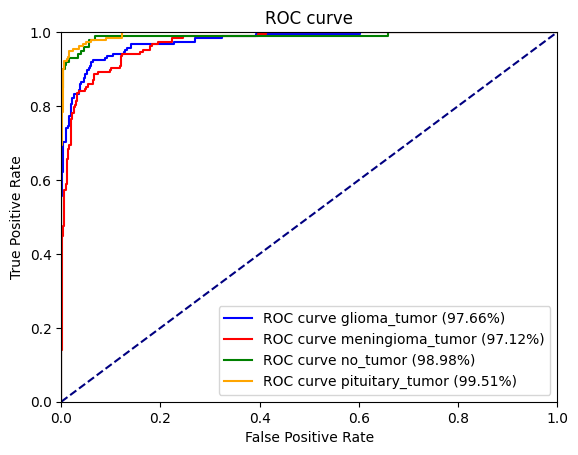

In [10]:
# Aggiungi un nuovo strato fully connected all'ultimo layer di VGG16
inputs = keras.Input(shape=(image_size, image_size, 3))
x = base_model(inputs)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(4, activation="softmax")(x)#4 classi di output
model = keras.Model(inputs=inputs, outputs=outputs)

# Congela i pesi del modello base, così da mantenere l'informazione appresa
for layer in base_model.layers:
    layer.trainable = False

# Compila il modello
compile_model(model)

# Addestra il modello
run_model(model,"VGG16","VGG16_128_dropout")

# Valuta il modello
evaluate_model(model,test_generator,"VGG16_128_dropout","VGG16")

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dense_5 (Dense)             (None, 4)                 516       
                                                                 
Total params: 14,780,868
Trainable params: 66,180
Non-trainable params: 14,714,688
__________________________________________

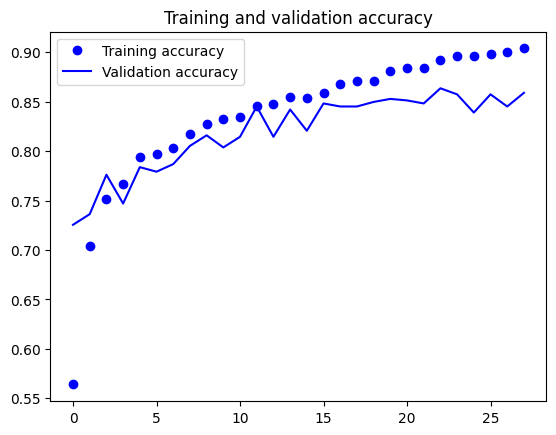

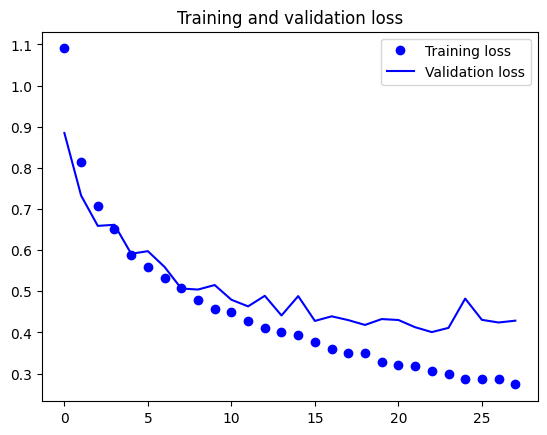

21/21 [==============================] - 4s 193ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.8698    0.7946    0.8305       185
meningioma_tumor     0.8187    0.7487    0.7821       187
        no_tumor     0.8174    0.9400    0.8744       100
 pituitary_tumor     0.8731    0.9556    0.9125       180

        accuracy                         0.8482       652
       macro avg     0.8448    0.8597    0.8499       652
    weighted avg     0.8480    0.8482    0.8460       652



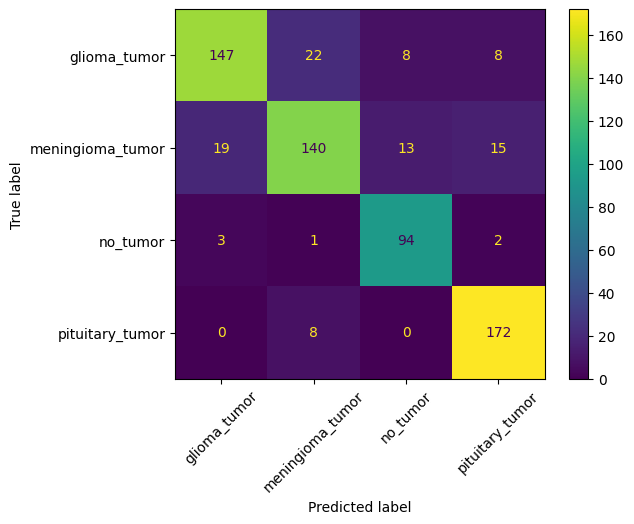

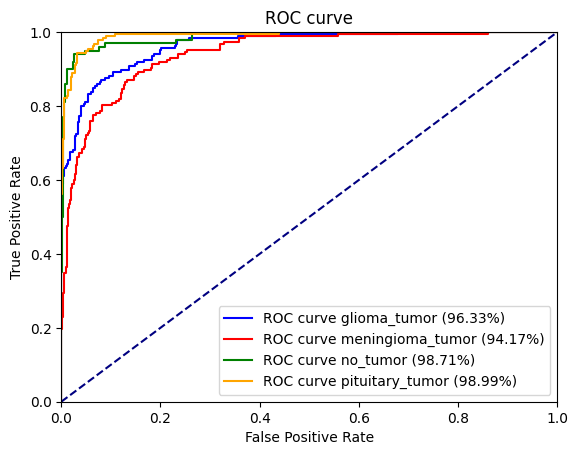

In [ ]:
# Aggiungi un nuovo strato fully connected all'ultimo layer di VGG16
inputs = keras.Input(shape=(image_size, image_size, 3))
x = base_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(4, activation="softmax")(x)#4 classi di output
model = keras.Model(inputs=inputs, outputs=outputs)

# Congela i pesi del modello base, così da mantenere l'informazione appresa
for layer in base_model.layers:
    layer.trainable = False

# Compila il modello
compile_model(model)

# Addestra il modello
run_model(model,"VGG16","VGG16_global_128")

# Valuta il modello
evaluate_model(model,test_generator,"VGG16_global_128","VGG16")

### suggerimento: 
Se dopo aver applicato il dropout la curva di validazione è più alta di quella di training, potrebbe essere un segnale di underfitting, ovvero il modello non è abbastanza complesso per adattarsi ai dati di training.

Il dropout è una tecnica di regolarizzazione che aiuta a prevenire l'overfitting. Essa consiste nel "spegnere" in modo casuale alcuni neuroni durante l'addestramento, in modo da forzare la rete a trovare più vie per rappresentare le relazioni tra le variabili di input.

Se la curva di validazione è più alta di quella di training dopo l'applicazione del dropout, potrebbe significare che la rete non è abbastanza complessa per adattarsi ai dati di training. In questo caso, si potrebbe provare ad aumentare la complessità della rete, aggiungendo più strati o più neuroni ai layer esistenti. In alternativa, si potrebbe provare ad aumentare la dimensione del dataset di training per avere più dati con cui addestrare la rete.

## Experiment 3
VGG16 + dense layer 256 neurons


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               6422784   
                                                                 
 dense_7 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 21,138,500
Trainable params: 6,423,812
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/100
142/142 [==================

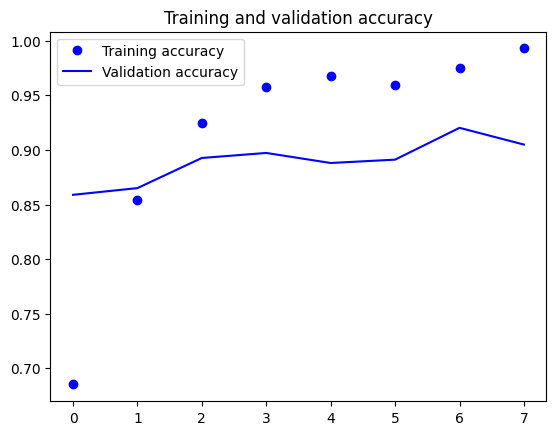

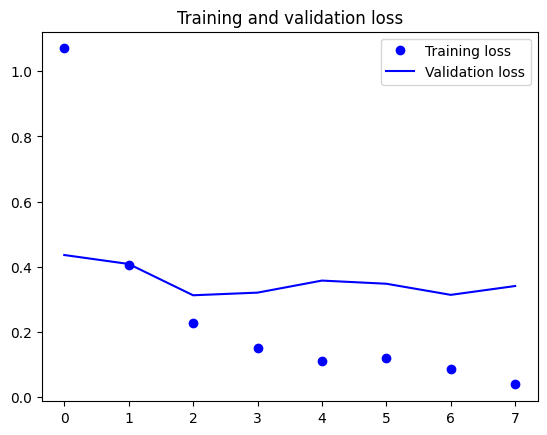

21/21 [==============================] - 5s 247ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.9277    0.8324    0.8775       185
meningioma_tumor     0.8077    0.8984    0.8506       187
        no_tumor     0.9208    0.9300    0.9254       100
 pituitary_tumor     0.9661    0.9500    0.9580       180

        accuracy                         0.8988       652
       macro avg     0.9056    0.9027    0.9029       652
    weighted avg     0.9028    0.8988    0.8994       652



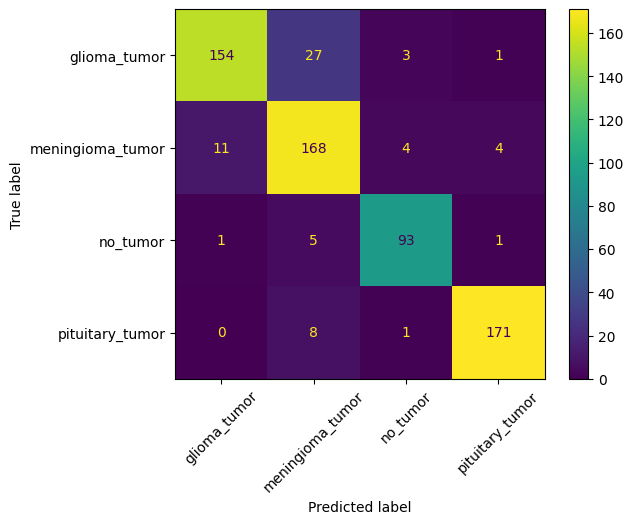

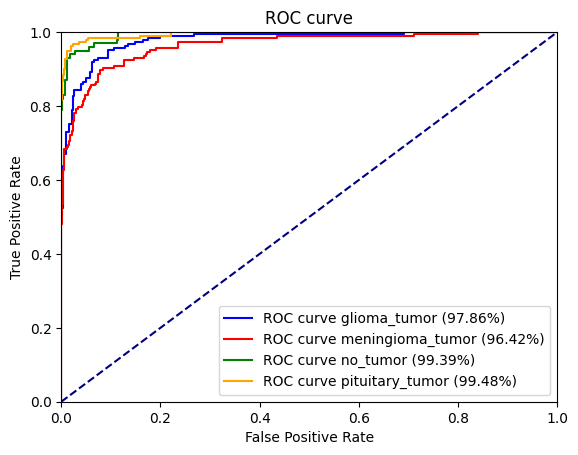

In [ ]:
# Aggiungi un nuovo strato fully connected all'ultimo layer di VGG16
inputs = keras.Input(shape=(image_size, image_size, 3))
x = base_model(inputs)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(4, activation="softmax")(x)#4 classi di output
model = keras.Model(inputs=inputs, outputs=outputs)

# Congela i pesi del modello base, così da mantenere l'informazione appresa
for layer in base_model.layers:
    layer.trainable = False

# Compila il modello
compile_model(model)

# Addestra il modello
run_model(model,"VGG16","VGG16_256")

# Valuta il modello
evaluate_model(model,test_generator,"VGG16_256","VGG16")

## Experiment 4
VGG16 + dense layer 256 neurons and dropout

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 25088)             0         
                                                                 
 dense_12 (Dense)            (None, 256)               6422784   
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 21,138,500
Trainable params: 6,423,812
Non-tr

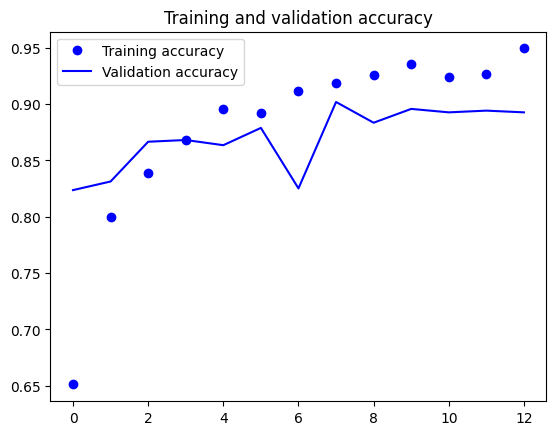

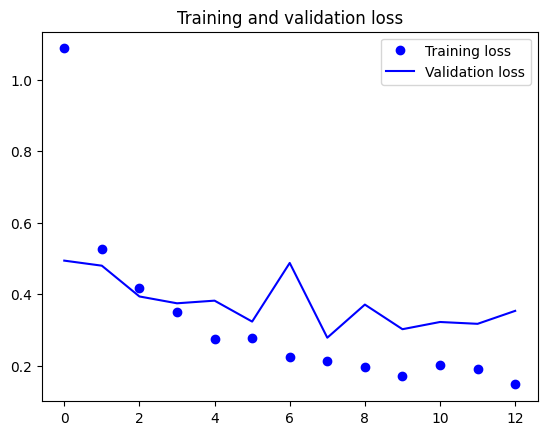

21/21 [==============================] - 5s 246ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.8950    0.8757    0.8852       185
meningioma_tumor     0.8384    0.8877    0.8623       187
        no_tumor     0.8785    0.9400    0.9082       100
 pituitary_tumor     0.9880    0.9111    0.9480       180

        accuracy                         0.8988       652
       macro avg     0.9000    0.9036    0.9009       652
    weighted avg     0.9019    0.8988    0.8995       652



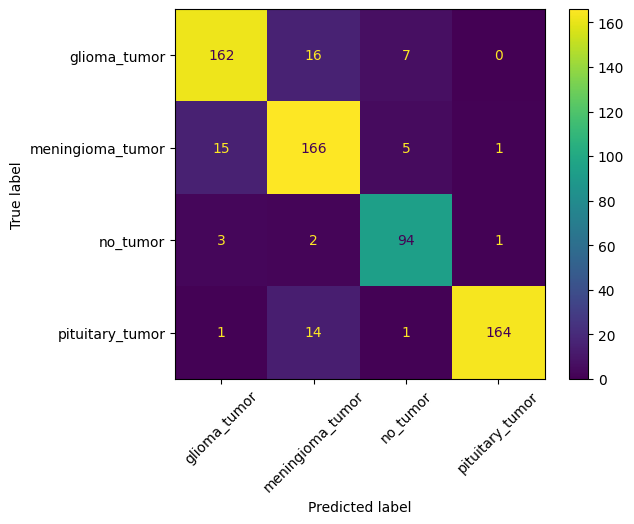

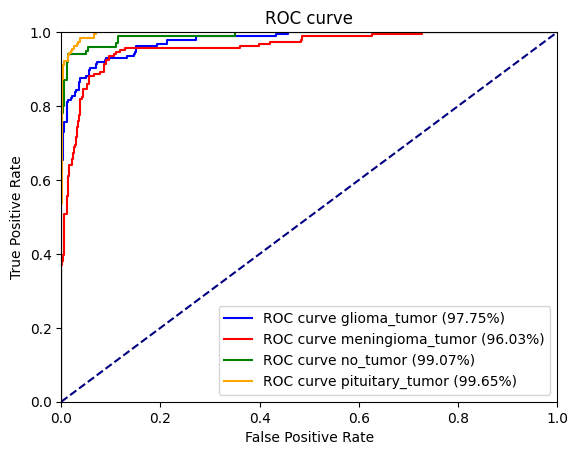

In [11]:
# Aggiungi un nuovo strato fully connected all'ultimo layer di VGG16
inputs = keras.Input(shape=(image_size, image_size, 3))
x = base_model(inputs)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(4, activation="softmax")(x)#4 classi di output
model = keras.Model(inputs=inputs, outputs=outputs)

# Congela i pesi del modello base, così da mantenere l'informazione appresa
for layer in base_model.layers:
    layer.trainable = False

# Compila il modello
compile_model(model)

# Addestra il modello
run_model(model,"VGG16","VGG16_256_dropout")

# Valuta il modello
evaluate_model(model,test_generator,"VGG16_256_dropout","VGG16")

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dense_11 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 14,847,044
Trainable params: 132,356
Non-trainable params: 14,714,688
_________________________________________

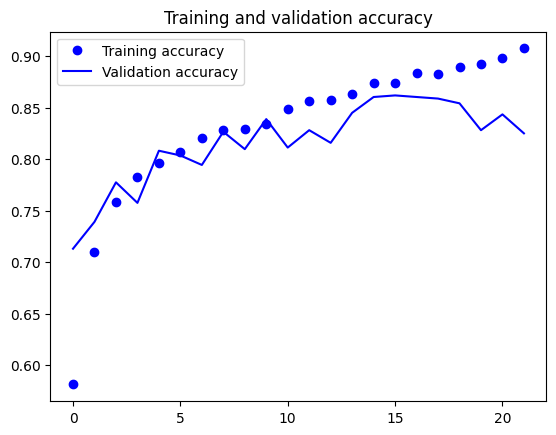

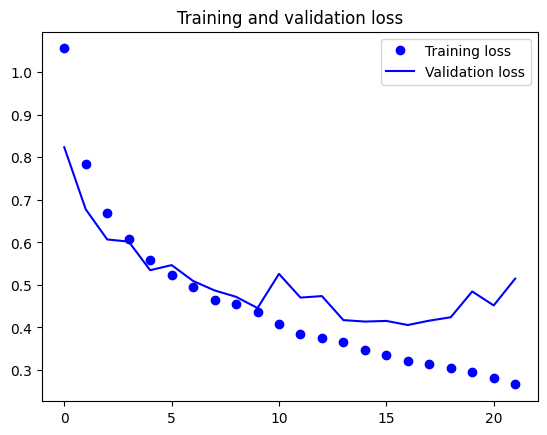

21/21 [==============================] - 5s 239ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.9512    0.6324    0.7597       185
meningioma_tumor     0.7512    0.8075    0.7784       187
        no_tumor     0.7899    0.9400    0.8584       100
 pituitary_tumor     0.8373    0.9722    0.8997       180

        accuracy                         0.8236       652
       macro avg     0.8324    0.8380    0.8241       652
    weighted avg     0.8377    0.8236    0.8189       652



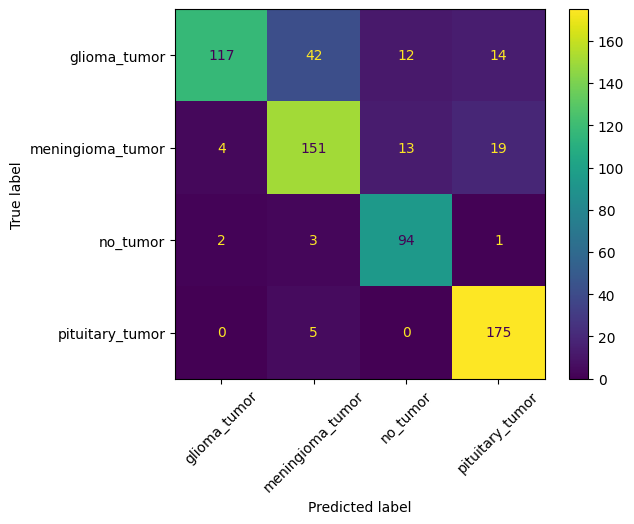

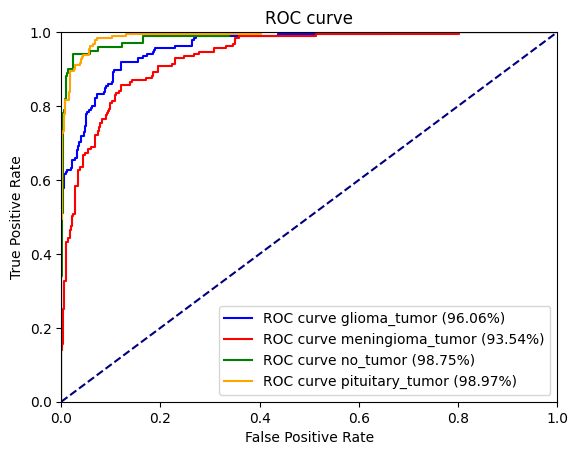

In [ ]:
# Aggiungi un nuovo strato fully connected all'ultimo layer di VGG16
inputs = keras.Input(shape=(image_size, image_size, 3))
x = base_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(4, activation="softmax")(x)#4 classi di output
model = keras.Model(inputs=inputs, outputs=outputs)

# Congela i pesi del modello base, così da mantenere l'informazione appresa
for layer in base_model.layers:
    layer.trainable = False

# Compila il modello
compile_model(model)

# Addestra il modello
run_model(model,"VGG16","VGG16_global_256")

# Valuta il modello
evaluate_model(model,test_generator,"VGG16_global_256","VGG16")

## Experiment 5
VGG16 + 2 dense layer 128 neurons and dropout

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 25088)             0         
                                                                 
 dense_14 (Dense)            (None, 128)               3211392   
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 128)               16512     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0   

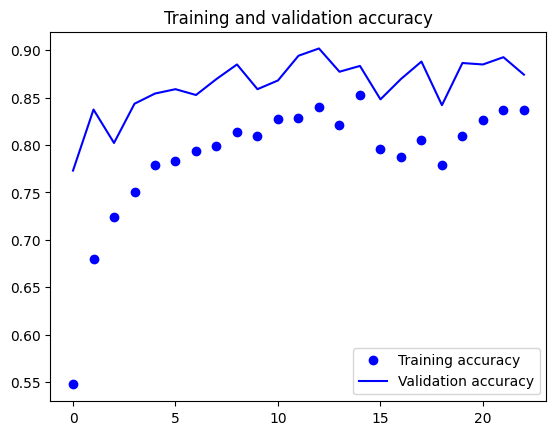

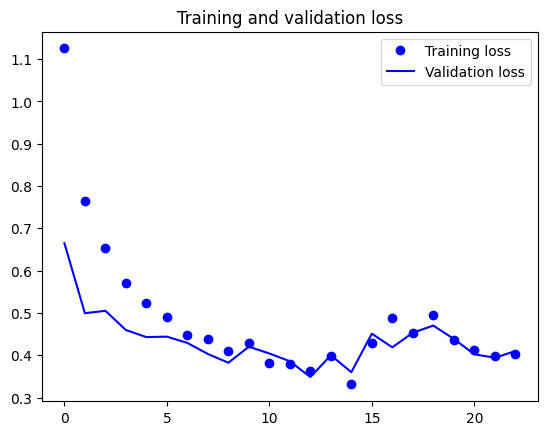

21/21 [==============================] - 5s 208ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.9470    0.7730    0.8512       185
meningioma_tumor     0.7174    0.8824    0.7914       187
        no_tumor     0.8980    0.8800    0.8889       100
 pituitary_tumor     0.9595    0.9222    0.9405       180

        accuracy                         0.8620       652
       macro avg     0.8805    0.8644    0.8680       652
    weighted avg     0.8771    0.8620    0.8645       652



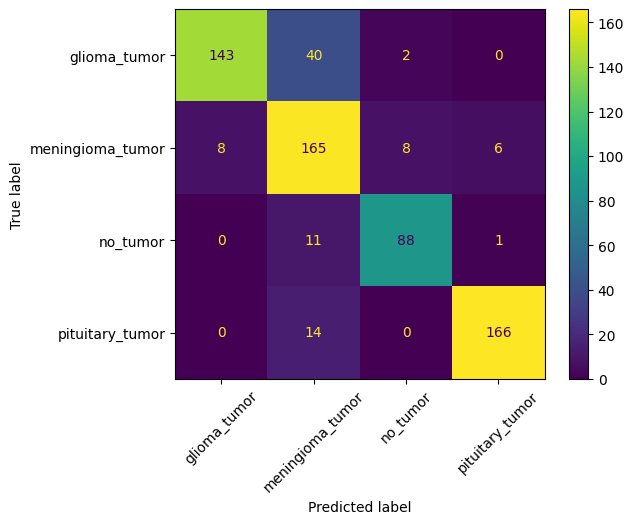

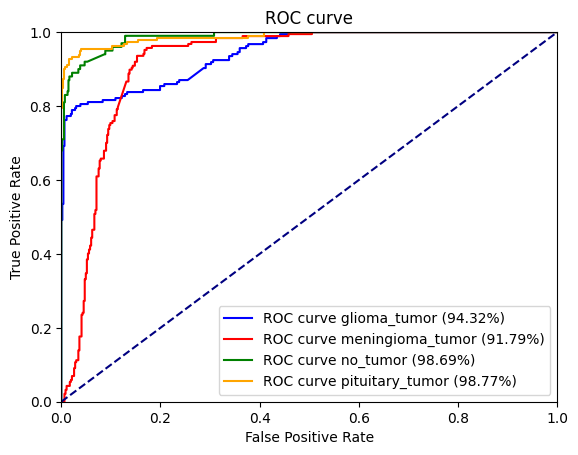

In [12]:
# Aggiungi un nuovo strato fully connected all'ultimo layer di VGG16
inputs = keras.Input(shape=(image_size, image_size, 3))
x = base_model(inputs)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(4, activation="softmax")(x)#4 classi di output
model = keras.Model(inputs=inputs, outputs=outputs)

# Congela i pesi del modello base, così da mantenere l'informazione appresa
for layer in base_model.layers:
    layer.trainable = False

# Compila il modello
compile_model(model)

# Addestra il modello
run_model(model,"VGG16","VGG16_128_128_dropout",100,10)

# Valuta il modello
evaluate_model(model,test_generator,"VGG16_128_128_dropout","VGG16")

## Experiment 6
VGG16 + GlobalAvgPooling + 2 dense layer 256 neurons and dropout

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_15 (Dense)            (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 256)               65792     
                                                           

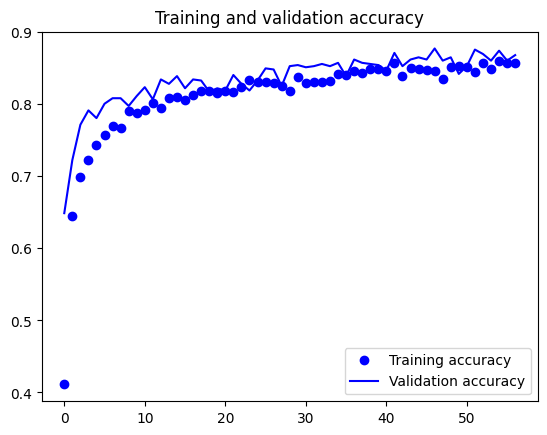

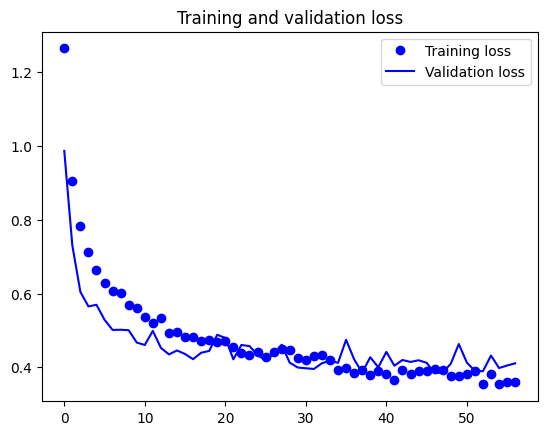

21/21 [==============================] - 4s 187ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.9108    0.7730    0.8363       185
meningioma_tumor     0.7783    0.8449    0.8103       187
        no_tumor     0.8468    0.9400    0.8910       100
 pituitary_tumor     0.9171    0.9222    0.9197       180

        accuracy                         0.8604       652
       macro avg     0.8633    0.8700    0.8643       652
    weighted avg     0.8648    0.8604    0.8602       652



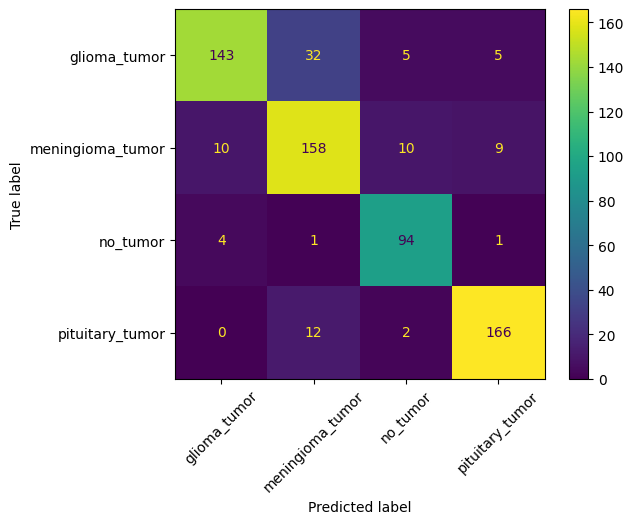

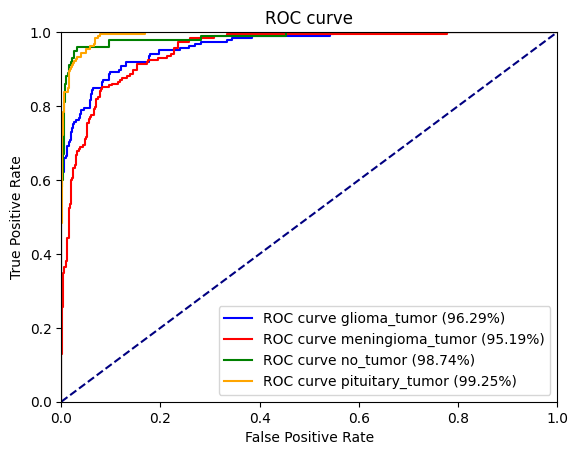

In [ ]:
# Aggiungi un nuovo strato fully connected all'ultimo layer di VGG16
inputs = keras.Input(shape=(image_size, image_size, 3))
x = base_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)#4 classi di output
model = keras.Model(inputs=inputs, outputs=outputs)

# Congela i pesi del modello base, così da mantenere l'informazione appresa
for layer in base_model.layers:
    layer.trainable = False

# Compila il modello
compile_model(model)

# Addestra il modello
run_model(model,"VGG16","VGG16_global_256_256_dropout",100,10)

# Valuta il modello
evaluate_model(model,test_generator,"VGG16_global_256_256_dropout","VGG16")

# Fine Tuning

In [5]:
#load best model
best_model_path = os.path.join(models_path, 'VGG16/VGG16_256_dropout.h5')
best_model_name = 'VGG16_256_dropout'
model = load_model(best_model_path)

## Unfreeze block5_conv3 

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

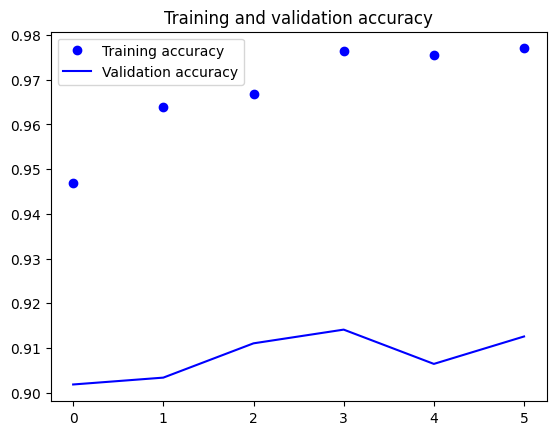

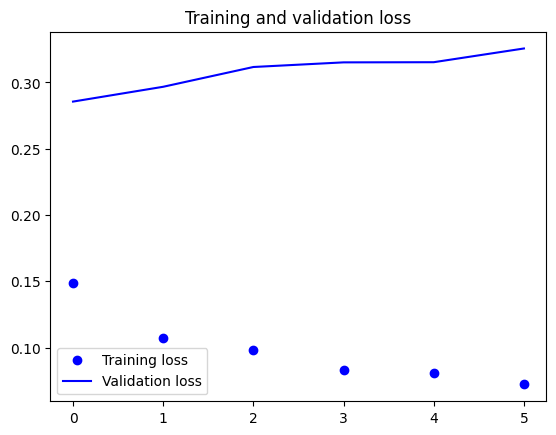

21/21 [==============================] - 286s 14s/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.9557    0.8162    0.8805       185
meningioma_tumor     0.8230    0.9198    0.8687       187
        no_tumor     0.9057    0.9600    0.9320       100
 pituitary_tumor     0.9553    0.9500    0.9526       180

        accuracy                         0.9049       652
       macro avg     0.9099    0.9115    0.9085       652
    weighted avg     0.9098    0.9049    0.9049       652



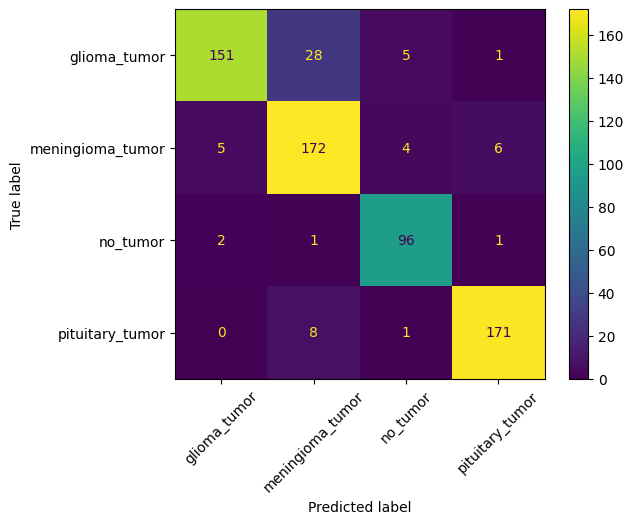

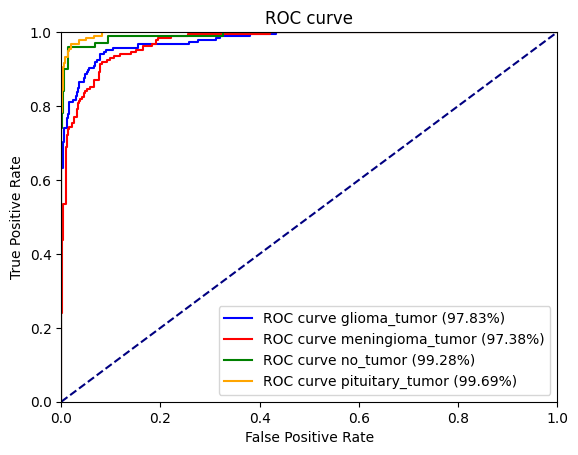

In [6]:
# Scongela i pesi del modello base
model.trainable = True
base_model = model.get_layer('vgg16')
base_model.summary()
# set to trainable all layers from block5_conv2
set_trainable = False
for layer in base_model.layers:
    if layer.name == 'block5_conv3':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# Compila il modello
compile_model(model,"adam",1e-5)

# Addestra il modello
run_model(model,"VGG16", best_model_name + "_finetuned")

# Evaluate model
evaluate_model(model,test_generator, best_model_name + "_finetuned", "VGG16")

## Unfreeze block5_conv2

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

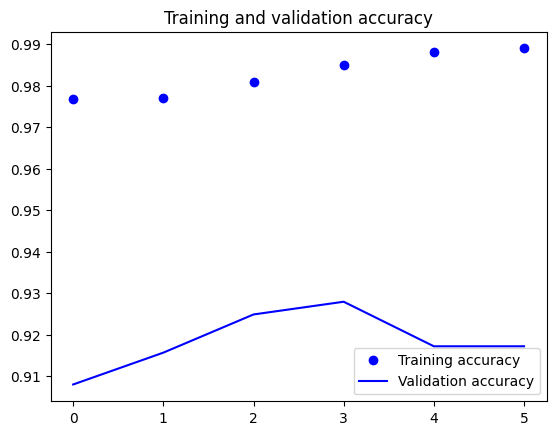

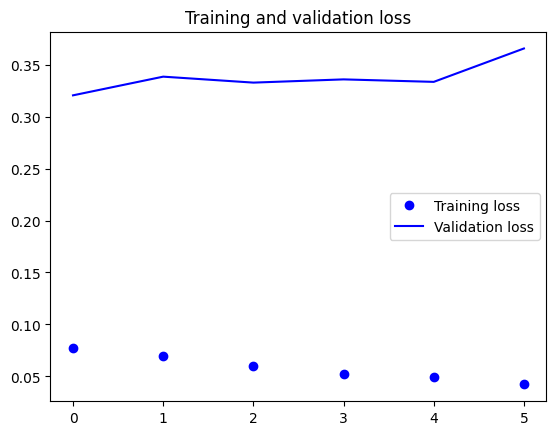

21/21 [==============================] - 5s 251ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.9091    0.8649    0.8864       185
meningioma_tumor     0.8710    0.8663    0.8686       187
        no_tumor     0.8649    0.9600    0.9100       100
 pituitary_tumor     0.9665    0.9611    0.9638       180

        accuracy                         0.9064       652
       macro avg     0.9029    0.9131    0.9072       652
    weighted avg     0.9072    0.9064    0.9063       652



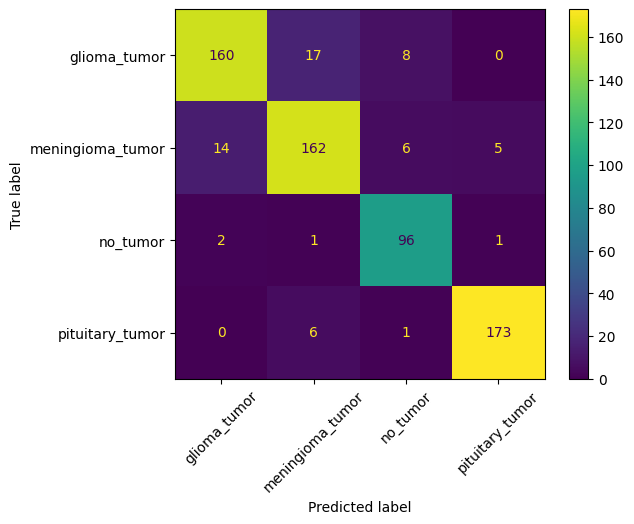

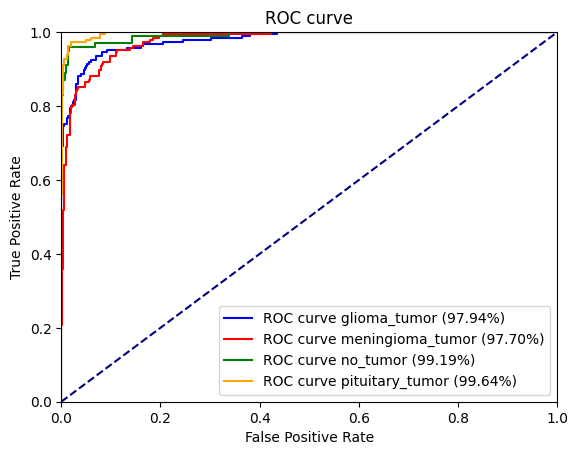

In [7]:
# Scongela i pesi del modello base
model.trainable = True
base_model = model.get_layer('vgg16')
base_model.summary()
# set to trainable all layers from block5_conv2
set_trainable = False
for layer in base_model.layers:
    if layer.name == 'block5_conv2':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# Compila il modello
compile_model(model,"adam",1e-5)

# Addestra il modello
run_model(model,"VGG16", best_model_name + "_finetuned")

# Evaluate model
evaluate_model(model,test_generator, best_model_name + "_finetuned", "VGG16")

## Unfreeze block5_conv1

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

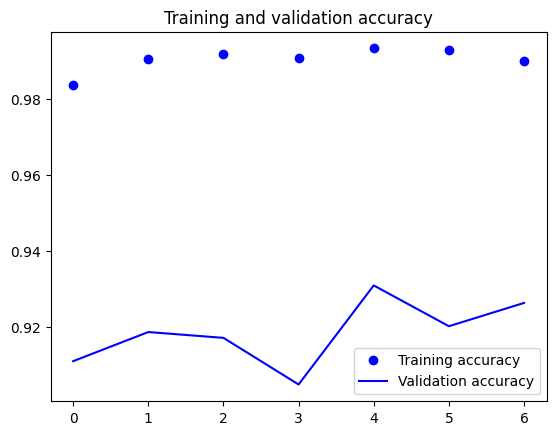

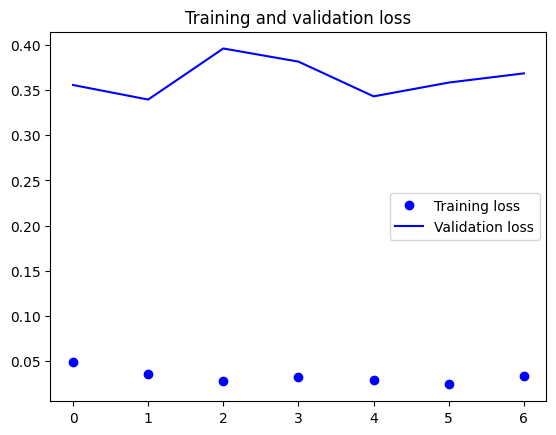

21/21 [==============================] - 5s 220ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.9464    0.8595    0.9008       185
meningioma_tumor     0.8458    0.9091    0.8763       187
        no_tumor     0.8962    0.9500    0.9223       100
 pituitary_tumor     0.9718    0.9556    0.9636       180

        accuracy                         0.9141       652
       macro avg     0.9150    0.9185    0.9158       652
    weighted avg     0.9169    0.9141    0.9144       652



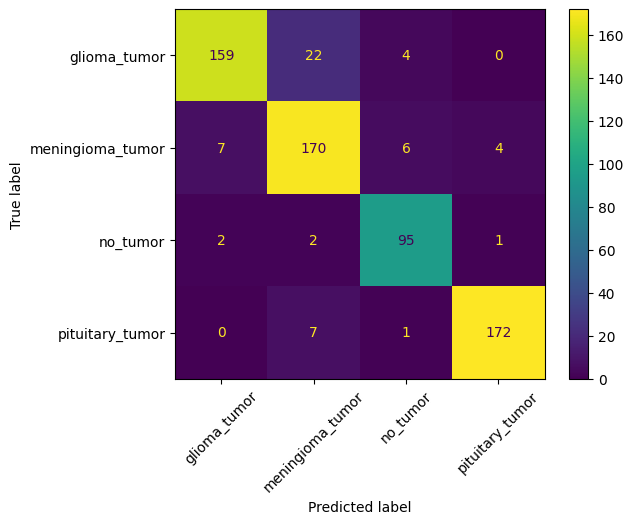

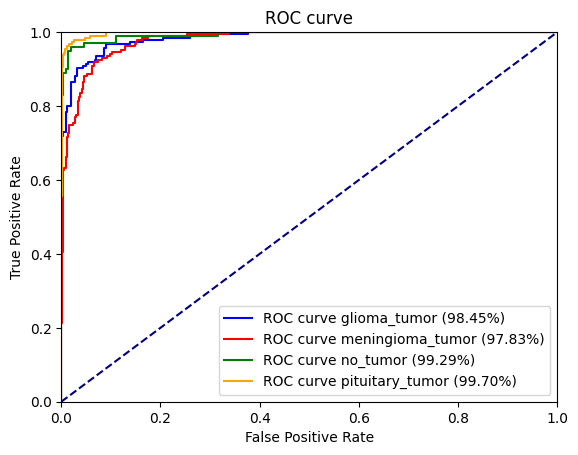

In [8]:
# Scongela i pesi del modello base
model.trainable = True
base_model = model.get_layer('vgg16')
base_model.summary()
# set to trainable all layers from block5_conv2
set_trainable = False
for layer in base_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# Compila il modello
compile_model(model,"adam",1e-5)

# Addestra il modello
run_model(model,"VGG16", best_model_name + "_finetuned")

# Evaluate model
evaluate_model(model,test_generator, best_model_name + "_finetuned", "VGG16")

## Unfreeze block4_conv1

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

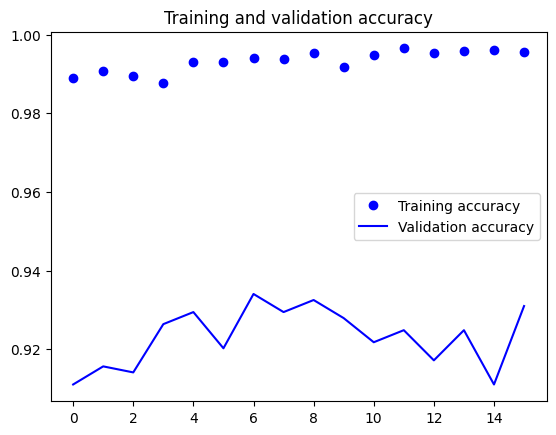

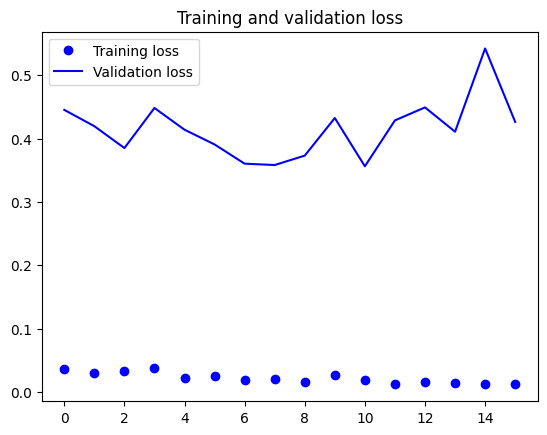

21/21 [==============================] - 5s 208ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.9016    0.8919    0.8967       185
meningioma_tumor     0.8579    0.8717    0.8647       187
        no_tumor     0.9300    0.9300    0.9300       100
 pituitary_tumor     0.9609    0.9556    0.9582       180

        accuracy                         0.9095       652
       macro avg     0.9126    0.9123    0.9124       652
    weighted avg     0.9098    0.9095    0.9096       652



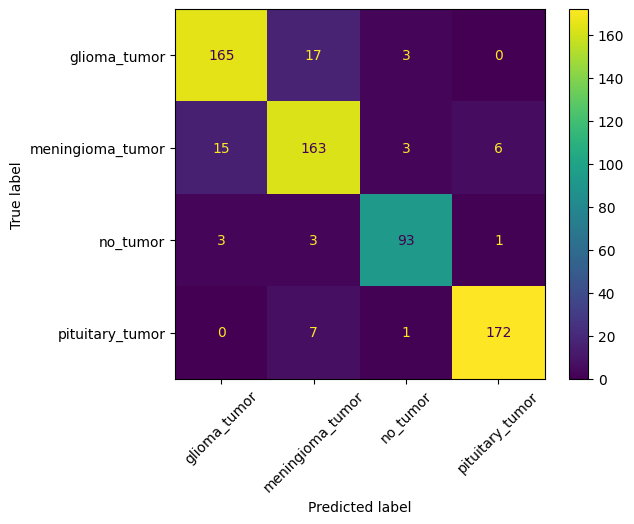

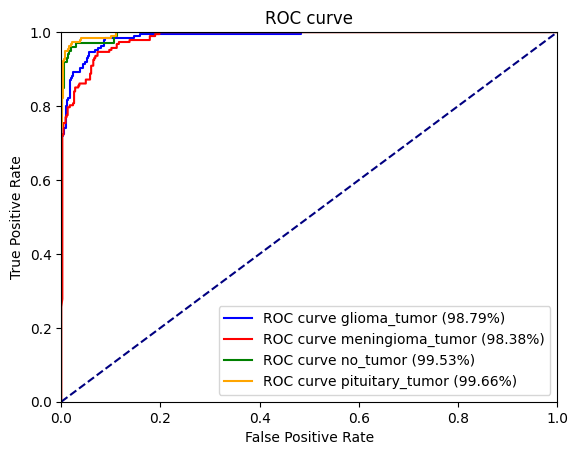

In [9]:
# Scongela i pesi del modello base
model.trainable = True
base_model = model.get_layer('vgg16')
base_model.summary()
# set to trainable all layers from block4_conv1
set_trainable = False
for layer in base_model.layers:
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# Compila il modello
compile_model(model,"adam",1e-5)

# Addestra il modello
run_model(model,"VGG16", best_model_name + "_finetuned")

# Evaluate model
evaluate_model(model,test_generator, best_model_name + "_finetuned", "VGG16")

## Unfreeze block3_conv1

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

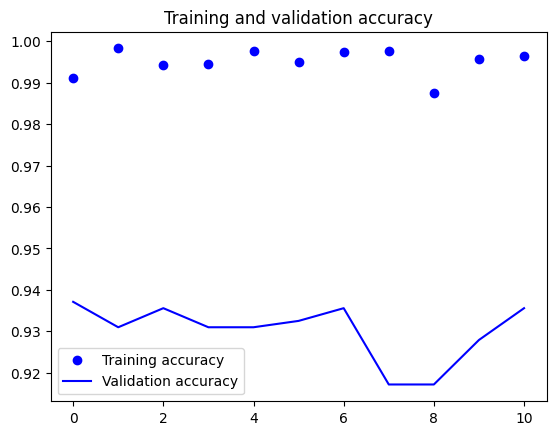

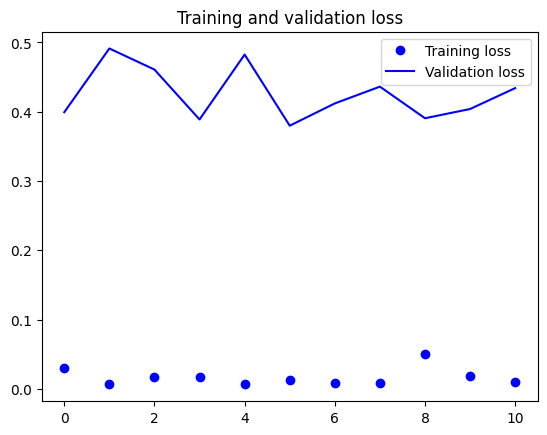

21/21 [==============================] - 6s 282ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.9337    0.9135    0.9235       185
meningioma_tumor     0.8995    0.9091    0.9043       187
        no_tumor     0.9143    0.9600    0.9366       100
 pituitary_tumor     0.9774    0.9611    0.9692       180

        accuracy                         0.9325       652
       macro avg     0.9312    0.9359    0.9334       652
    weighted avg     0.9330    0.9325    0.9326       652



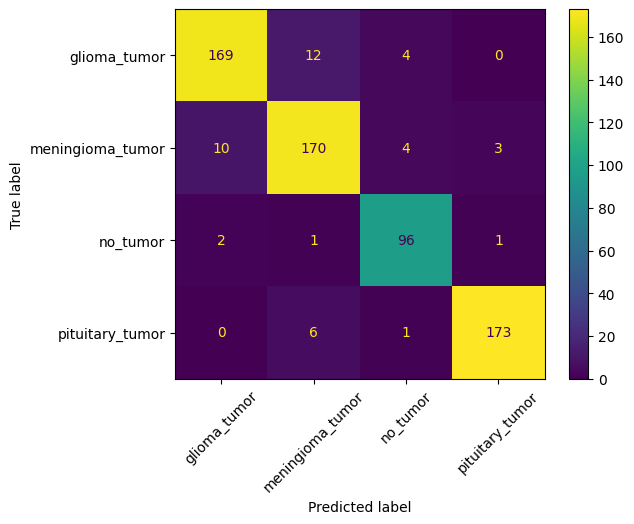

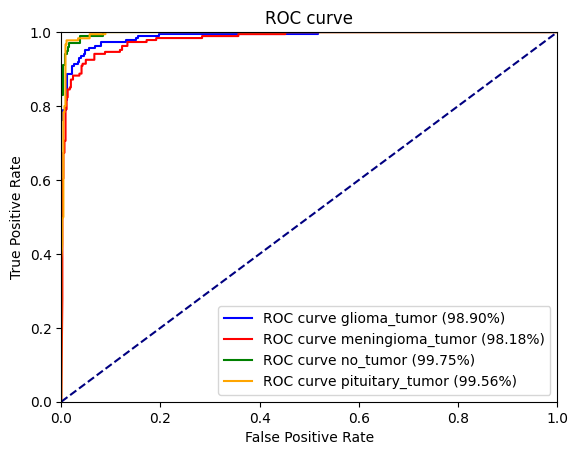

In [10]:
# Scongela i pesi del modello base
model.trainable = True
base_model = model.get_layer('vgg16')
base_model.summary()
# set to trainable all layers from block4_conv1
set_trainable = False
for layer in base_model.layers:
    if layer.name == 'block3_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# Compila il modello
compile_model(model,"adam",1e-5)

# Addestra il modello
run_model(model,"VGG16", best_model_name + "_finetuned")

# Evaluate model
evaluate_model(model,test_generator, best_model_name + "_finetuned", "VGG16")